In [20]:
%pylab inline
import re
import pymongo
import pylab
from multiprocessing import Pool
from collections import Counter

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
client = pymongo.MongoClient('localhost', 27017)
db = client.get_database('tvtropes')
media_collection = db.get_collection('media')
trope_collection = db.get_collection('tropes')

In [17]:
def sanitize_link(link_txt):
    # + shows a specific bullet
    link_txt = link_txt.replace('+ ', '')
    # * is another kind of bullet
    link_txt = link_txt.replace('* ', '')
    # no parenthesis, colons or triple-apostrophes
    link_txt = link_txt.replace('[[', '').replace(']]', '')
    link_txt = link_txt.replace('{{', '').replace('}}', '')
    link_txt = link_txt.replace(':', '')
    link_txt = link_txt.replace('\'\'\'', '')
    link_txt = link_txt.replace('\'\'', '')
    # only the first word
    try:
        link_txt = link_txt.split()[0]
    except IndexError:
        link_txt = ''
    return link_txt

In [11]:
def get_tropes_from_source(page_src):
    try:
        page_src = page_src.split('----')[1]
    except IndexError:
        return []
    page_lines = page_src.split('<br>')
    return [sanitize_link(i) for i in page_lines if i.startswith('* ')]

In [15]:
def get_tropes_from_document(document):
    result = get_tropes_from_source(document['source'])
    if 'subpage_sources' in document:
        for i in document['subpage_sources']:
            result.extend(get_tropes_from_source(i))
    return result

In [18]:
for media in media_collection.find({'$and': [{'source': {'$exists': True}}, {'redirect': {'$exists': False}}]}):
    current_tropes = get_tropes_from_document(media)
    current_trope_ids = [trope_collection.find_one({'name': i}) for i in current_tropes]
    current_trope_ids = [i['_id'] for i in current_trope_ids if i is not None]
    media_collection.find_one_and_update({'_id':media['_id']}, {"$set": {'tropes': current_tropes}})
    media_collection.find_one_and_update({'_id':media['_id']}, {"$set": {'trope_ids': current_trope_ids}})

In [3]:
print(media_collection.find({'$and': [{'source': {'$exists': True}}, {'redirect': {'$exists': False}}]}).count())
print(media_collection.find({'tropes': {'$exists': True}}).count())
print(media_collection.find({'trope_ids': {'$exists': True}}).count())

41327
41327
41327


In [20]:
def get_namespace_from_page(page_src, namespace):
    """example namespaces: Literature, Film, WesternAnimation
    """
    pattern = re.compile(namespace + '/\w+', flags=re.I)
    return pattern.findall(page_src)

In [4]:
NAMESPACES = ['Disney', 'Literature', 'Franchise', 'Theatre', 'Blog', 'Wrestling', 'Advertising', 'WebVideo', 'Machinima', 'VisualNovel', 'WebAnimation', 'Magazine', 'Webcomic', 'Pinball', 'WebOriginal', 'Animation', 'Series', 'Roleplay', 'Toys', 'ComicBook', 'Discworld', 'Radio', 'Fanfic', 'Myth', 'TabletopGame', 'ComicStrip', 'VideoGame', 'Website', 'Music', 'WesternAnimation', 'Manhwa', 'Manga', 'LightNovel', 'Anime', 'Film']
NAMESPACE_PATTERNS = dict([(i, re.compile(i + '/\w+', flags=re.I)) for i in NAMESPACES])
print(NAMESPACE_PATTERNS)

{'Blog': re.compile('Blog/\\w+', re.IGNORECASE), 'Disney': re.compile('Disney/\\w+', re.IGNORECASE), 'VideoGame': re.compile('VideoGame/\\w+', re.IGNORECASE), 'Theatre': re.compile('Theatre/\\w+', re.IGNORECASE), 'Myth': re.compile('Myth/\\w+', re.IGNORECASE), 'Animation': re.compile('Animation/\\w+', re.IGNORECASE), 'Webcomic': re.compile('Webcomic/\\w+', re.IGNORECASE), 'Music': re.compile('Music/\\w+', re.IGNORECASE), 'Discworld': re.compile('Discworld/\\w+', re.IGNORECASE), 'Pinball': re.compile('Pinball/\\w+', re.IGNORECASE), 'Toys': re.compile('Toys/\\w+', re.IGNORECASE), 'Manga': re.compile('Manga/\\w+', re.IGNORECASE), 'WesternAnimation': re.compile('WesternAnimation/\\w+', re.IGNORECASE), 'Series': re.compile('Series/\\w+', re.IGNORECASE), 'WebAnimation': re.compile('WebAnimation/\\w+', re.IGNORECASE), 'Manhwa': re.compile('Manhwa/\\w+', re.IGNORECASE), 'Anime': re.compile('Anime/\\w+', re.IGNORECASE), 'Advertising': re.compile('Advertising/\\w+', re.IGNORECASE), 'Wrestling': 

In [5]:
def get_media_from_trope(trope_src):
    result = []
    for i in NAMESPACE_PATTERNS.items():
        result.extend([(i[0],j) for j in i[1].findall(trope_src)])
    return result

In [6]:
def add_media_links_to_trope(trope):
    current_media = get_media_from_trope(trope['source'])
    current_media_ids = [media_collection.find_one({'name': i[1], 'namespace': i[0]}) for i in current_media]
    current_media_ids = [i['_id'] for i in current_media_ids if i is not None]
    trope_collection.find_one_and_update({'_id': trope['_id']}, {"$set": {'media': current_media}})
    trope_collection.find_one_and_update({'_id': trope['_id']}, {"$set": {'media_ids': current_media_ids}})

In [7]:
pool = Pool(processes=6)
pool.map(add_media_links_to_trope, trope_collection.find())

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [8]:
# we have a slightly wrong format of media fields and empty media_ids fields
def fix_media(media_list):
    return [[i[0], i[1].split('/')[1]] for i in media_list]

In [9]:
for trope in trope_collection.find():
    trope_collection.find_one_and_update({'_id': trope['_id']}, {"$set": {'media': fix_media(trope['media'])}})

In [11]:
def fix_media_ids(trope):
    current_media_ids = [media_collection.find_one({'name': i[1], 'namespace': i[0]}) for i in trope['media']]
    current_media_ids = [i['_id'] for i in current_media_ids if i is not None]
    trope_collection.find_one_and_update({'_id': trope['_id']}, {"$set": {'media_ids': current_media_ids}})

pool = Pool(processes=7)
pool.map(fix_media_ids, trope_collection.find())

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

## Validation

In [13]:
media2trope_link_lens = [(len(i.get('tropes', [])), len(i.get('trope_ids', []))) for i in media_collection.find()]

In [14]:
trope2media_link_lens = [(len(i.get('media', [])), len(i.get('media_ids', []))) for i in trope_collection.find()]

(array([  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   4.00000000e+00,
          5.95590000e+04]),
 array([-4141. , -3726.9, -3312.8, -2898.7, -2484.6, -2070.5, -1656.4,
        -1242.3,  -828.2,  -414.1,     0. ]),
 <a list of 10 Patch objects>)

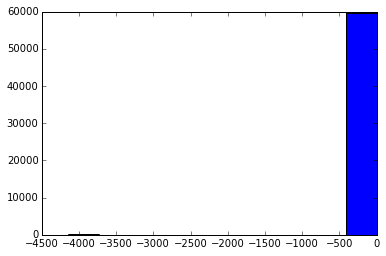

In [17]:
pylab.hist([i[1] - i[0] for i in media2trope_link_lens])

(array([     0.,      0.,      0.,      0.,      0.,  15892.,      0.,
             0.,      0.,      0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

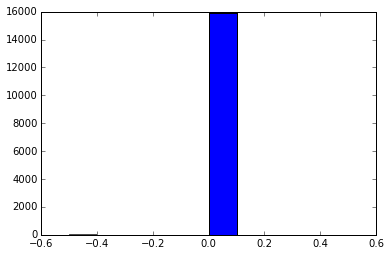

In [18]:
pylab.hist([i[1] - i[0] for i in trope2media_link_lens])

In [22]:
print(Counter([i[1] - i[0] for i in media2trope_link_lens]))
print(Counter([i[1] - i[0] for i in trope2media_link_lens]))

Counter({0: 25823, -4: 2111, -5: 2063, -3: 1984, -6: 1816, -2: 1796, -7: 1756, -8: 1530, -1: 1498, -9: 1460, -10: 1258, -11: 1109, -12: 1047, -13: 935, -14: 855, -15: 829, -16: 710, -17: 667, -18: 632, -19: 587, -20: 486, -21: 448, -22: 402, -23: 396, -24: 363, -25: 360, -26: 317, -27: 309, -28: 290, -30: 264, -31: 248, -29: 245, -33: 212, -34: 211, -35: 209, -32: 196, -37: 181, -38: 178, -39: 161, -40: 153, -36: 152, -41: 144, -44: 129, -42: 121, -43: 120, -46: 106, -45: 104, -49: 93, -48: 92, -47: 91, -54: 90, -52: 86, -50: 74, -59: 70, -57: 70, -51: 70, -55: 65, -60: 62, -58: 61, -56: 61, -53: 59, -65: 53, -68: 51, -61: 47, -64: 46, -75: 39, -71: 38, -62: 36, -69: 33, -81: 32, -76: 31, -63: 31, -72: 30, -66: 30, -67: 29, -74: 27, -70: 27, -73: 26, -83: 25, -93: 23, -89: 22, -86: 22, -84: 22, -88: 21, -80: 21, -110: 20, -108: 19, -96: 19, -95: 19, -82: 19, -79: 19, -77: 19, -101: 18, -87: 18, -78: 18, -107: 17, -121: 15, -97: 15, -94: 15, -92: 15, -124: 14, -109: 14, -100: 14, -99: 1

In [24]:
Counter([(i[1]-i[0])==0 for i in media2trope_link_lens])

Counter({False: 33741, True: 25823})

(array([  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
        

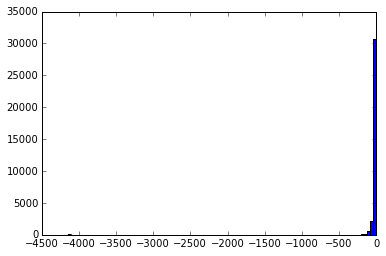

In [27]:
pylab.hist([i[1]-i[0] for i in media2trope_link_lens if i[0]!=i[1]], bins=100)